# ROSA experiments GrIS April/May 2021

This notebook deals with the data processing (filtering & analysis) of the experiments carried out using the Rain On Snow Appliance (ROSA) on the Greenland Ice Sheet between April 18th and May 16th 2021.

Last edit: Nicole Clerx, November 2021

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import csv
import matplotlib.dates as dates
import math
from matplotlib import rc

## File locations & metadata loading
Specifying directories & filenames

In [5]:
data_dir = 'pub//ROSA'
photo_dir = 'pub//ROSA//pictures'
output_dir = 'pub//ROSA//output'

fn_exp = os.path.join(data_dir,'experiment_metadata.xlsx')
exp_info = pd.read_excel(fn_exp, sheet_name = 'experiments',index_col=0,header=0)

fn_data = os.path.join(data_dir,'ROSA_CR1000_Table1.dat')
alldata = pd.read_csv(fn_data,skiprows=[0,2,3],header=0,parse_dates=True,index_col='TIMESTAMP',na_values='NAN')

cal_info = pd.read_csv('pub//ROSA//weightscales_calibration_coefficients.csv',index_col='weightclass')

Specifying information variables

In [18]:
exps = list(exp_info.columns)
paper_exps = [2,4,5,6,7,8]
sides = ['front','left','back','right']
variables_metadata = list(exp_info.index)
variables_datalogger = list(alldata.columns)

## Data loading
Creating dictionary for experiment data as recorded by the datalogger for all ROSA-experiments (ignoring first snow experiment (20210427_1620_snow1) since very incomplete metadata and skipping first firn experiment (20210428_1630_firn1) since no data recorded on logger).  
Experiment start and end times are taken as timing of removing and reinserting the dripping plate. 


In [19]:
exp_data = {}

for exp in exps:
    start = alldata.index.get_loc(exp_info[exp].drplate_out_DT,method='nearest')
    end = alldata.index.get_loc(exp_info[exp].drplate_in_DT,method='nearest')
    exp_data[exp] = alldata.iloc[start:end]
    

## Firn block volume calculation
Reshuffling input data to create a dictionary containing average width and height for each block to calculate (initial) densities.  
Block volumes are calculated using:  
> average front/back width   **x**   average left/right face width   =   block area  
> average height from all sides (9 measurements)

In [20]:
avg_dims = {}

for exp in exps:
    ht = 0
    w = 0
    for side in sides:
        ht = ht + exp_info.loc[str(side)+'_h']
        w = w + exp_info.loc[str(side)+'_w']
#         print(a)
    avg_dims['height_m']=ht/400
    avg_dims['width_m']=w/400

In [21]:
avg_dims['height_m']

20210427_1620_snow1         0.2
20210427_1820_snow2     0.19625
20210429_1630_firn1     0.15875
20210429_1900_firn2    0.168333
20210501_1400_firn3    0.171667
20210501_1900_firn4    0.275417
20210502_1400_firn5    0.186667
20210502_2030_firn6      0.1325
20210503_1330_snow3     0.18375
dtype: object

## Calculations
Data manipulation and calculating various parameters  
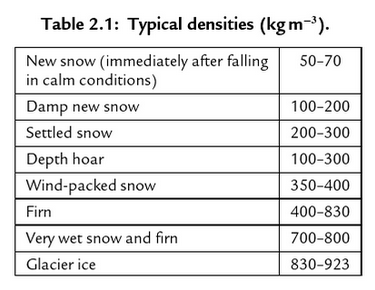  
*From Cuffey & Paterson, p. 12, Table 2.1*

Appending experiment metadata dataframe with calculated initial parameters

Since it is clear that the sensor weight is negligible (from `exp_info.tail()`, max. 400 g / ~1% of total weight in each experiment) and the uncertainty is high (for some experiments the initial weight noted down manually is higher than the weight measured after sensors were included), the variable `initwt_kg_withsensors` is used for density and further calculations.

Cross-checking the manually noted mV-value with average measured values in the datalogger (commented out code) is not that straightforward since the time interval for which this can be done is different between the various experiments (and rather arbitrary).  
*Not critical at this point, could do this later if deemed valuable.*

### Experiment properties
Calculations to determine: 
- total firn block weight in kg
- firn block density
- inflow and outflow per 10 second measuring interval
- cumulative in- and outflow
- LWC (assuming initial LWC = 0 and no refreezing takes place/all added density remains in the form of liquid water)
- time of start of continuous outflow, time lag between experiment and outflow start

In [22]:
for exp in exps:
    initwt_sensors_loc = alldata.index.get_loc(exp_info[exp].sensors_in_end_DT,method='nearest')
    initwt_start_loc = alldata.index.get_loc(exp_info[exp].drplate_out_DT,method='nearest')

    exp_info.loc['initwt_kg_nosensors_manual',exp] = exp_info[exp].weight_initial_mV*cal_info.loc[exp_info[exp].weightclass].slope + cal_info.loc[exp_info[exp].weightclass].intercept
    exp_info.loc['initwt_kg_withsensors',exp] = alldata.Tot_weight[initwt_sensors_loc:initwt_start_loc].mean()*cal_info.loc[exp_info[exp].weightclass].slope + cal_info.loc[exp_info[exp].weightclass].intercept
    exp_info.loc['area',exp] = avg_dims['width_m'][exp]**2
    exp_info.loc['height',exp] = avg_dims['height_m'][exp]
    exp_info.loc['volume_m3',exp] = (avg_dims['height_m'][exp])*((avg_dims['width_m'][exp])**2)
    if exp == exps[0]:
        exp_info.loc['initrho_kgm3',exp] = exp_info.loc['initwt_kg_nosensors_manual',exp]/exp_info[exp].volume_m3
    else:
        exp_info.loc['initrho_kgm3',exp] = exp_info.loc['initwt_kg_withsensors',exp]/exp_info[exp].volume_m3
    exp_info.loc['porosity',exp] = 1 - exp_info[exp].initrho_kgm3 / 917 # porosity based on initial (assumed dry) firn/snow density after Cuffey & Paterson (2010)
    
    exp_data[exp].loc[:,'tot_weight_kg'] = exp_data[exp].loc[:,'Tot_weight']*cal_info.loc[exp_info[exp].weightclass].slope + cal_info.loc[exp_info[exp].weightclass].intercept
    exp_data[exp].loc[:,'density_kgm3'] = exp_data[exp]['tot_weight_kg'] / exp_info[exp].volume_m3
    exp_data[exp].loc[:,'inflow_int_L'] = exp_data[exp]['FC_Flow_in']*.01/60 # total water volume added per time interval/measurement
    exp_data[exp].loc[:,'inflow_cum_L'] = exp_data[exp]['inflow_int_L'].cumsum(axis=0) # cumulative water inflow
    exp_data[exp].loc[:,'outflow_int_L'] = (exp_data[exp]['Rain_mm_1']+exp_data[exp]['Rain_mm_2'])*12/1000 # outflow volume per time interval/measurement
    exp_data[exp].loc[:,'outflow_cum_L'] = exp_data[exp]['outflow_int_L'].cumsum(axis=0) # cumulative water outflow
    exp_data[exp].loc[:,'added_mass_kg'] = (exp_data[exp].tot_weight_kg.diff().rolling(window=6).mean()).cumsum(axis=0)
    exp_data[exp].loc[:,'added_mass_perc'] = exp_data[exp].loc[:,'added_mass_kg'] / exp_info.loc['initwt_kg_nosensors_manual',exp] * 100
    exp_data[exp].loc[:,'LWC'] = (exp_data[exp].density_kgm3.diff().rolling(window=6).mean()).cumsum(axis=0)/10 # assuming initial LWC = 0 and no refreezing takes place (all added density is liquid water)
    
    exp_info.loc['endrho_kgm3',exp] = exp_data[exp].iloc[exp_data[exp].index.get_loc(pd.to_datetime(exp_info[exp].sensors_out_DT),method='nearest')].density_kgm3
    exp_info.loc['endweight_kg',exp] = exp_data[exp].iloc[exp_data[exp].index.get_loc(pd.to_datetime(exp_info[exp].sensors_out_DT),method='nearest')].tot_weight_kg
    exp_info.loc['porosity_end',exp] = 1 - exp_info[exp].endrho_kgm3 / 917
    exp_info.loc['duration',exp] = exp_info[exp].drplate_in_DT-exp_info[exp].drplate_out_DT
    exp_info.loc['delta_density',exp] = exp_info.loc['endrho_kgm3',exp] - exp_info.loc['initrho_kgm3',exp]
    exp_info.loc['delta_weight',exp] = exp_info.loc['endweight_kg',exp] - exp_info.loc['initwt_kg_withsensors',exp]
    exp_info.loc['delta_porosity',exp] = (exp_info[exp].endrho_kgm3 - exp_info[exp].initrho_kgm3) / 917
    
    
    if exp_data[exp].outflow_cum_L[-1] > 3*0.012:
        exp_info.loc['outflow_start_DT',exp] = exp_data[exp].iloc[((exp_data[exp].outflow_cum_L > (10*0.012)).searchsorted('True',side='left')-10)].name
        exp_info.loc['outflow_lag',exp] = exp_info.loc['outflow_start_DT',exp] - exp_info.loc['drplate_out_DT',exp]
        exp_info.loc['outflow_duration',exp] = exp_info[exp].duration - exp_info.loc['outflow_lag',exp]
        exp_info.loc['outflow_volume_L',exp] = exp_data[exp].outflow_cum_L[-1]
        


C:\Users\ClerxN\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ClerxN\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
print('initial sample properties:')
print('weight [kg]:','%3.2f' % exp_info.loc['initwt_kg_nosensors_manual'].min(),'-','%3.2f' % exp_info.loc['initwt_kg_nosensors_manual'].max())
print('density [kg/m3]:','%3.2f' % exp_info.loc['initrho_kgm3'].min(),'-','%3.2f' % exp_info.loc['initrho_kgm3'].max())
print('porosity [-]:','%3.2f' % exp_info.loc['porosity'].min(),'-','%3.2f' % exp_info.loc['porosity'].max(),'\n')

print('differences:')
print('delta weight [kg]:','%3.2f' % (exp_info.loc['endweight_kg']-exp_info.loc['initwt_kg_withsensors']).min(),'-','%3.2f' % (exp_info.loc['endweight_kg']-exp_info.loc['initwt_kg_withsensors']).max())
print('delta density [kg/m3]:','%3.2f' % exp_info.loc['delta_density'].min(),'-','%3.2f' % exp_info.loc['delta_density'].max())
print('delta porosity [-]:','%3.2f' % exp_info.loc['delta_porosity'].min(),'-','%3.2f' % exp_info.loc['delta_porosity'].max())

initial sample properties:
weight [kg]: 30.54 - 71.50
density [kg/m3]: 406.09 - 600.35
porosity [-]: 0.35 - 0.56 

differences:
delta weight [kg]: 2.96 - 7.56
delta density [kg/m3]: 37.04 - 85.65
delta porosity [-]: 0.04 - 0.09


### Flow around ice lens in firn4-experiment (20210501_1900_firn4)

In [37]:
exp = exps[-4]
print(exp,'\navg. flow not through block [ml/min]: 35 ml/min')
print('avg. outflow [ml/min]',format(np.mean(exp_data[exp].loc[exp_info[exp].outflow_start_DT:].outflow_int_L)*6000,'.3f'))
print('last outflow [ml/min]',format(exp_data[exp].outflow_cum_L[-1]*1000 / (exp_info[exp].outflow_duration.seconds/60),'.3f'))

print('avg. outflow through ice lens[mm/10 s]',format((np.mean(exp_data[exp].loc[exp_info[exp].outflow_start_DT:].outflow_int_L)/exp_info[exp].area)*(35/42),'.3f'))

20210501_1900_firn4 
avg. flow not through block [ml/min]: 35 ml/min
avg. outflow [ml/min] 41.790
last outflow [ml/min] 44.056
avg. outflow through ice lens[mm/10 s] 0.012


### Permeability 
Calculating open porosity using Schwander (1989) empirical relationship (following Adolph & Albert, 2014)

$\phi_c = \phi \exp [75*(\frac{\rho(z)}{\rho_{co}}-1)]$ &emsp;&emsp;&nbsp;&nbsp; for &emsp; $0 < \rho(z) < \rho_{co}$  
$\phi_c = \phi$  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; for &emsp; $0 < \rho(z) < \rho_{co}$  

Estimating close-off density from the Martinerie et al. (1994) parametrisation yields a value of 0.823 g ${cm^{-3}}$. Since initial densities of all firn samples used in the experiments are largely smaller than this density, the uppermost parametrisation for closed porosity is used.

The following parametrisations for permeability are used to compare their results:  

|<div style = 'width:160px'>Author </div>|<div style='width:270px'> Parametrisation </div>| <div style='width=320px'>Comments</div>|
:---|:---|:---
|Freitag et al. (2002)|$k = 10^{-7.7} m^2 \phi_o^{3.4}$| |
|Adolph $\&$ Albert (2014)|$k = 10^{-7.29} m^2 \phi_o^{3.71}$|open porosity; m ~ 1.5 for Summit firn|
| |$k = 10^{-7.53} m^2 \phi^{2.74}$|total porosity; m ~ 1.5 for Summit firn| 
|Calonne et al. (2012)|$k = 3.0 \pm 0.3 (r_{es}^2 \exp((-0.0130 \pm 0.0003)\rho_s)$|$r_{es}$ equivalent sphere radius|  
|Shimizu (1970)|$k = 0.077 d_o^2 \exp[-7.8\rho_s^* ]$|$\rho_s^*$ specific gravity of snow|
|Brinkman (1947)|$k = 0.56 d_o^2 \exp[-11.5\rho_s^* ]$|from Shimizu (1970) $\rho_s^*$ specific gravity of snow|



In [28]:
rho_co = 823            # Pore close-off density (in kg m^-3) as estimated folling the parametrisation from Martinerie et al. (1994). after Adolph & Albert (2014)
d = {}                  # Grain diameter (estimated/assumed) for all experiments (in m) - assumed 0.5 mm diameter for snow, 1 mm diameter for firn
for exp in exps:
    exp_info.loc['por_open',exp] = exp_info.loc['porosity',exp] - exp_info.loc['porosity',exp]*np.exp(75*(exp_info.loc['initrho_kgm3',exp]/rho_co-1))
    if 'snow' in exp:
        d[exp] = 1e-3
    else:
        d[exp] = 2e-3

In [29]:
permeability = {key:{'Freitag':None,'Adolph_openpor':None,'Adolph_totalpor':None,'Calonne':None,'Shimizu':None,'Brinkman':None,'Darcy_avg':None,'Darcy_final':None} for key in exps}

for exp in exps:
    exp_info.loc['por_open',exp] = exp_info.loc['porosity',exp] - exp_info.loc['porosity',exp]*np.exp(75*(exp_info.loc['initrho_kgm3',exp]/rho_co-1))
    permeability[exp]['Freitag'] = 10**-7.7 * 1.5**2 * exp_info.loc['por_open',exp]**3.4
    permeability[exp]['Adolph_openpor'] = 10**-7.29 * 1.5**2 * exp_info.loc['por_open',exp]**3.71
    permeability[exp]['Adolph_totalpor'] = 10**-7.53 * 1.5**2 * exp_info.loc['porosity',exp]**2.74
    permeability[exp]['Calonne_highhigh'] = (3 + 0.3)*(0.5*d[exp])**2*np.exp((-0.013+0.0003)*exp_info.loc['initrho_kgm3',exp])
    permeability[exp]['Calonne_lowlow'] = (3 - 0.3)*(0.5*d[exp])**2*np.exp((-0.013-0.0003)*exp_info.loc['initrho_kgm3',exp])
    permeability[exp]['Calonne_highlow'] = (3 + 0.3)*(0.5*d[exp])**2*np.exp((-0.013-0.0003)*exp_info.loc['initrho_kgm3',exp])
    permeability[exp]['Calonne_lowhigh'] = (3 - 0.3)*(0.5*d[exp])**2*np.exp((-0.013+0.0003)*exp_info.loc['initrho_kgm3',exp])
    permeability[exp]['Shimizu'] = 0.077 * d[exp]**2 * np.exp(-7.8*exp_info.loc['initrho_kgm3',exp]/1000)
    permeability[exp]['Brinkman'] = 0.56 * d[exp]**2 * np.exp(-11.5*exp_info.loc['initrho_kgm3',exp]/1000)
    
permeability = pd.DataFrame(permeability).T


### Hydraulic conductivity
Calculated using the various permeability parametrisations following:   
$K = \frac{k\rho g}{\mu}$  
where  
-- *K* is hydraulic conductivity  
-- $\rho$ is fluid density [*kg* $m^{-3}$]  
-- *g* is gravitational acceleration [9.81 *m* $s^{-2}$]  
-- $\mu$ is the fluid dynamic viscosity [Pa$\cdot$s = kg $m^{-1} s^{-1}$]

Calculated using Darcy's law as:  
$-K = \frac{Q}{A}$  
where  
--*K* is hydraulic conductivity (sometimes also called Darcy velocity) [m/s]  
-- *Q* is discharge [$m^3$*/s*]  
-- *A* is area through which flow occurs [$m^2$]



In [30]:
mu = 0.0017919 # water dynamic viscosity at 0°C [Pa.s]
K = {key:{'Freitag':None,'Adolph_openpor':None,'Adolph_totalpor':None,'Calonne':None,'Shimizu':None,'Brinkman':None,'Darcy_avg':None,'Darcy_final':None} for key in exps}
# Values for K in m/s
K_temp = []

for exp in exps:
    for column in permeability.columns:
        K[exp][column] = (permeability.loc[exp,column]*9.81*1000)/(mu)
    K_temp = (exp_data[exp].outflow_int_L.rolling(window=12).mean().dropna()/10 / exp_info[exp].area)
    exp_data[exp].loc[:,'K_Darcy'] = K_temp
    
    K_temp = (K_temp*mu)/(9.81*1000)
    exp_data[exp].loc[:,'permeability_Darcy'] = K_temp
    
#     finds average of K in the last 15 minutes before shutting down the pumps:
    if exp == exps[3]:
        K[exp]['Darcy_final'] = exp_data[exp].iloc[exp_data[exp].index.get_loc(pd.to_datetime(exp_info[exp].exp_issues_DT),method='nearest')-90:exp_data[exp].index.get_loc(pd.to_datetime(exp_info[exp].exp_issues_DT),method='nearest')].K_Darcy.mean()
    else:
        K[exp]['Darcy_final'] = exp_data[exp].iloc[exp_data[exp].index.get_loc(pd.to_datetime(exp_info[exp].pumps_off_DT),method='nearest')-90:exp_data[exp].index.get_loc(pd.to_datetime(exp_info[exp].pumps_off_DT),method='nearest')].K_Darcy.mean()
    permeability.loc[exp,'Darcy_final'] = (K[exp]['Darcy_final']*mu)/(9.81*1000)
    
#     Unsure if the below calculations hold
    if exp_data[exp].outflow_cum_L[-1] > 3*0.012:
        K[exp]['Darcy_avg'] = (exp_data[exp].outflow_cum_L[-1]/exp_info[exp].outflow_duration.seconds) / exp_info[exp].area
        permeability.loc[exp,'Darcy_avg'] = (K[exp]['Darcy_avg']*mu)/(9.81*1000)
        exp_info.loc['K_unsaturated',exp] =  exp_info[exp].height / exp_info[exp].outflow_lag.seconds
        
    exp_info.loc['K_Darcy_avg',exp] = K[exp]['Darcy_avg']
    exp_info.loc['K_Darcy_final',exp] = K[exp]['Darcy_final']
    exp_info.loc['permeability_Darcy_avg',exp] = permeability.loc[exp,'Darcy_avg']
    exp_info.loc['permeability_Darcy_final',exp] = permeability.loc[exp,'Darcy_final']
    exp_info.loc['Res_from_Darcypermeability',exp] = np.sqrt(permeability.loc[exp,'Darcy_final'] / (3*np.exp(-0.013*exp_info[exp].initrho_kgm3)))
    
    
        
# for exp in exps:
#     print(exp,' rho_init:',format(exp_info[exp].initrho_kgm3,'.2f'),'kg m^-3,  K : ',format(K[exp]['Darcy_avg']*60,'.3f'),'m/hr,  k : ',format(permeability.loc[exp,'Darcy_avg'],'.3e'))
    

In [32]:
K = pd.DataFrame.from_dict(K)
K

20210427_1620_snow1  20210427_1820_snow2  \
Freitag                      0.031899             0.026951   
Adolph_openpor               0.068065             0.056630   
Adolph_totalpor              0.070131             0.061224   
Calonne                           NaN                  NaN   
Shimizu                      0.016687             0.013803   
Brinkman                     0.026230             0.019829   
Darcy_avg                         NaN                  NaN   
Darcy_final                  0.000000             0.000000   
Calonne_highhigh             0.023513             0.017263   
Calonne_lowlow               0.015006             0.010858   
Calonne_highlow              0.018341             0.013271   
Calonne_lowhigh              0.019238             0.014125   

                  20210429_1630_firn1  20210429_1900_firn2  \
Freitag                      0.023123             0.024627   
Adolph_openpor               0.047914             0.051322   
Adolph_totalpor              0.054114             0.056932   
Calonne                           NaN                  NaN   
Shimizu                      0.046838             0.050071   
Brinkman                     0.062238             0.068672   
Darcy_avg                    0.001584             0.000594   
Darcy_final                  0.001953             0.000474   
Calonne_highhigh             0.052831             0.058894   
Calonne_lowlow               0.032811             0.036765   
Calonne_highlow              0.040103             0.044935   
Calonne_lowhigh              0.043225             0.048186   

                  20210501_1400_firn3  20210501_1900_firn4  \
Freitag                      0.006614             0.012533   
Adolph_openpor               0.012226             0.024558   
Adolph_totalpor              0.019735             0.033032   
Calonne                           NaN                  NaN   
Shimizu                      0.015603             0.026006   
Brinkman                     0.012309             0.026140   
Darcy_avg                    0.003061             0.001509   
Darcy_final                  0.003557             0.002238   
Calonne_highhigh             0.008823             0.020269   
Calonne_lowlow               0.005035             0.012031   
Calonne_highlow              0.006154             0.014705   
Calonne_lowhigh              0.007219             0.016584   

                  20210502_1400_firn5  20210502_2030_firn6  \
Freitag                      0.015936             0.008670   
Adolph_openpor               0.031918             0.016428   
Adolph_totalpor              0.040088             0.024546   
Calonne                           NaN                  NaN   
Shimizu                      0.032348             0.019148   
Brinkman                     0.036061             0.016645   
Darcy_avg                    0.002810             0.003124   
Darcy_final                  0.003039             0.002622   
Calonne_highhigh             0.028916             0.012313   
Calonne_lowlow               0.017455             0.007139   
Calonne_highlow              0.021333             0.008725   
Calonne_lowhigh              0.023659             0.010074   

                  20210503_1330_snow3  
Freitag                      0.033640  
Adolph_openpor               0.072129  
Adolph_totalpor              0.073200  
Calonne                           NaN  
Shimizu                      0.017751  
Brinkman                     0.028733  
Darcy_avg                    0.002582  
Darcy_final                  0.002848  
Calonne_highhigh             0.026002  
Calonne_lowlow               0.016674  
Calonne_highlow              0.020380  
Calonne_lowhigh              0.021275

In [33]:
print('unsaturated flow velocity (block height / lag time)')
print('min:',format((exp_info.loc['K_unsaturated']*3600).min(),'.3f'),'m/hr (',format((exp_info.loc['K_unsaturated']).min(),'.3e'),'m/s)')
print('max:',format((exp_info.loc['K_unsaturated']*3600).max(),'.3f'),'m/hr (',format((exp_info.loc['K_unsaturated']).max(),'.3e'),'m/s)')
print('avg:',format((exp_info.loc['K_unsaturated']*3600).mean(),'.3f'),'m/hr (',format((exp_info.loc['K_unsaturated']).mean(),'.3e'),'m/s)')
print('1 std:',format((exp_info.loc['K_unsaturated']*3600).std(),'.3f'),'m/hr (',format((exp_info.loc['K_unsaturated']).std(),'.3e'),'m/s)')

print((0.01)/exp_info.loc['area'][5])

unsaturated flow velocity (block height / lag time)
min: 0.167 m/hr ( 4.649e-05 m/s)
max: 0.438 m/hr ( 1.217e-04 m/s)
avg: 0.247 m/hr ( 6.869e-05 m/s)
1 std: 0.091 m/hr ( 2.535e-05 m/s)
0.020554720520034427


### Percolation velocity before water breakthrough / continuous outflow

In [34]:
for exp in exps:
    if pd.isnull(exp_info[exp].outflow_lag) == 0:
        exp_info.loc['K_unsaturated',exp] = exp_info[exp].height / exp_info[exp].outflow_lag.seconds

### Saving output to Excel-file

In [36]:
with pd.ExcelWriter(os.path.join(output_dir,'ROSA_dataanalysis_output.xlsx')) as writer:
    exp_info.iloc[-22:].to_excel(writer, sheet_name='exp_info')
    for exp in exps:
        exp_data[exp].iloc[:,-11:].to_excel(writer, sheet_name=exp)


## Plotting
-- sensor values over time (firn temperatures, TDR-probes)  
-- ambient conditions (air temperature/humidity, water temperature)  
-- total inflow volume (rate * elapsed time)  
-- inflow (rate)  
-- outflow (volume)  
-- outflow (rate)  
-- SWE (wt / area)  
-- LWC (100 * (wt_end - wt_init) / area)  
-- normalised weight (wt / area over time)

-- density vs. lag time  
-- normalised initial vs. final density  
-- density increase vs. total water added / total outflow volume


### Cross plots

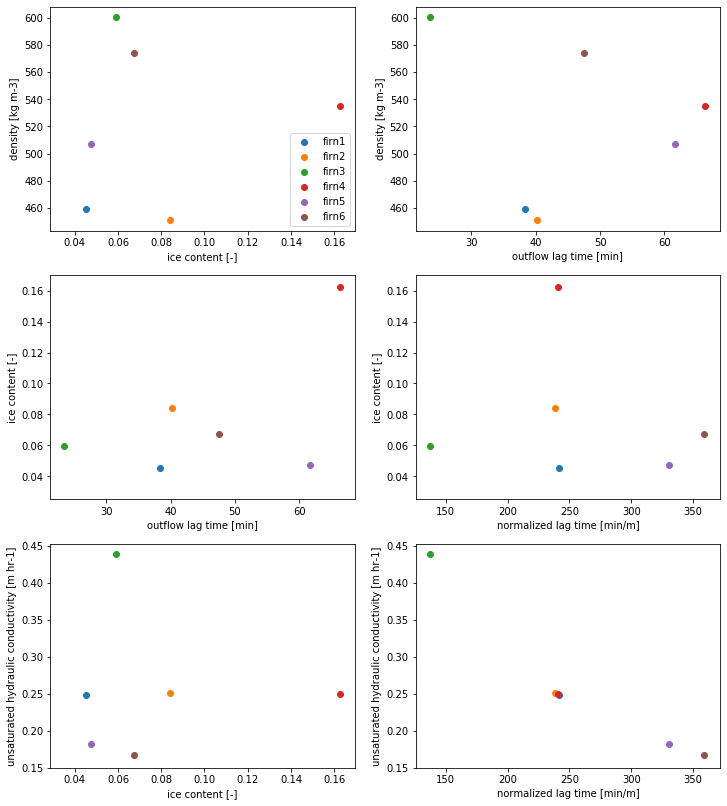

In [38]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(12,14))

for exp in exps[2:-1]:
    ax1.scatter(exp_info[exp].icecontent_perc,exp_info[exp].initrho_kgm3,marker='o',label=exp[-5:])
    ax2.scatter((exp_info[exp].outflow_lag/np.timedelta64(1,'m')),exp_info[exp].initrho_kgm3,marker='o')
    ax3.scatter((exp_info[exp].outflow_lag/np.timedelta64(1,'m')),exp_info[exp].icecontent_perc)
    ax4.scatter(((exp_info[exp].outflow_lag/np.timedelta64(1,'m'))/exp_info[exp].height),exp_info[exp].icecontent_perc)
#     ax5.scatter(exp_info[exp].icecontent_perc,exp_info[exp].K_Darcy_final*3600)
    ax5.scatter(exp_info[exp].icecontent_perc, exp_info[exp].K_unsaturated*3600)
#     ax6.scatter((exp_info[exp].outflow_lag/np.timedelta64(1,'m')),exp_info[exp].K_Darcy_final*3600)
    ax6.scatter((exp_info[exp].outflow_lag/np.timedelta64(1,'m'))/exp_info[exp].height,exp_info[exp].K_unsaturated*3600)

ax1.set_xlabel('ice content [-]')
ax1.set_ylabel('density [kg m-3]')
ax2.set_xlabel('outflow lag time [min]')    
ax2.set_ylabel('density [kg m-3]')
ax3.set_xlabel('outflow lag time [min]')
ax3.set_ylabel('ice content [-]')
ax4.set_xlabel('normalized lag time [min/m]')
ax4.set_ylabel('ice content [-]')
ax5.set_xlabel('ice content [-]')
# ax5.set_ylabel('saturated hydraulic conductivity [m hr-1]')
ax5.set_ylabel('unsaturated hydraulic conductivity [m hr-1]')
ax6.set_xlabel('normalized lag time [min/m]')
# ax6.set_ylabel('saturated hydraulic conductivity [m hr-1]')
ax6.set_ylabel('unsaturated hydraulic conductivity [m hr-1]')
# fig.subplots_adjust(center=0.9)
ax1.legend(loc='lower right')

#### Density vs. hydraulic conductivity

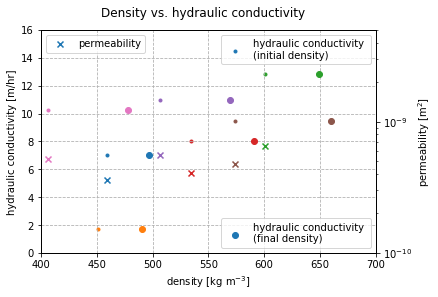

In [54]:
fig, ax1 = plt.subplots(figsize=(6,4))
fig.subplots_adjust(top=0.9)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes',1))

for exp in exps[2:]:
    ax1.scatter(exp_info[exp].initrho_kgm3,K[exp]['Darcy_final']*3600,marker='.')
    ax2.scatter(exp_info[exp].endrho_kgm3,K[exp]['Darcy_final']*3600,label='final density')
    ax3.scatter(exp_info[exp].initrho_kgm3,permeability.loc[exp,'Darcy_final'],marker='x',label='Darcy\'s law permeability')
    
ax1.set_xlabel('density [kg $\mathregular{m^{-3}}$]')
ax1.set_ylabel('hydraulic conductivity [m/hr]')
ax1.set_xlim([400,700])
ax1.set_ylim([0,16])
ax2.set_xlim([400,700])
ax2.set_xticks([])
ax3.set_ylim([10e-11,5e-9])
ax3.set_yscale('log')
ax3.set_ylabel('permeability [$\mathregular{m^{2}}$]')
ax1.grid(linestyle='--')
fig.suptitle('Density vs. hydraulic conductivity')
ax1.legend(labels=['hydraulic conductivity \n(initial density)'],loc='upper right')
ax2.legend(labels=['hydraulic conductivity \n(final density)'],loc='lower right')
ax3.legend(labels=['permeability'],loc='upper left')


#### Outflow vs. density increase

Text(0.5, 0.98, 'Cumulative outflow vs. density increase')

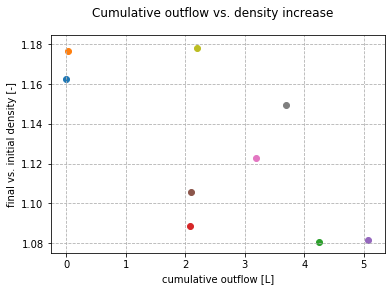

In [48]:
fig, ax1 = plt.subplots(figsize=(6,4))

for exp in exps:
    ax1.scatter(exp_data[exp].outflow_cum_L[-1],exp_info[exp].endrho_kgm3/exp_info[exp].initrho_kgm3,label=exp)
    
ax1.set_xlabel('cumulative outflow [L]')
ax1.set_ylabel('final vs. initial density [-]')
ax1.grid(linestyle='--')
# ax1.legend(loc='lower left')
fig.suptitle('Cumulative outflow vs. density increase') 

#### Initial density vs. density increase

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()

for exp in exps:
    ax1.scatter(exp_info[exp].initrho_kgm3,exp_info[exp].endrho_kgm3/exp_info[exp].initrho_kgm3,label=exp)
    ax2.scatter(exp_info[exp].initrho_kgm3,exp_info[exp].endrho_kgm3-exp_info[exp].initrho_kgm3,marker='x')
    
ax1.set_xlabel('initial density [kg $\mathregular{m^{-3}}$]')
ax1.set_ylabel('final vs. initial density [-]')
ax2.set_ylabel('total density increase [kg $\mathregular{m^{-3}}$]')
ax2.set_ylim([-20,100])
# ax1.grid(linestyle='--')
# ax1.legend()
fig.suptitle('Initial density vs. density increase')

#### Initial density vs. outflow and final density

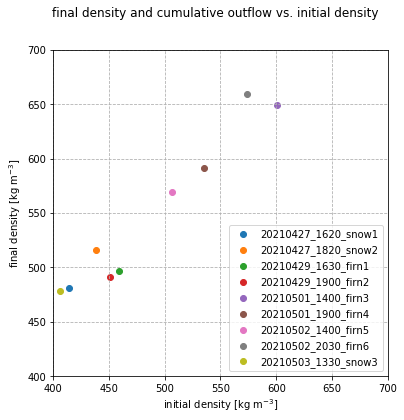

In [56]:
fig, ax1 = plt.subplots(figsize=(6,6))

for exp in exps:
    ax1.scatter(exp_info[exp].initrho_kgm3,exp_info[exp].endrho_kgm3,label=exp)

ax1.set_xlabel('initial density [kg $\mathregular{m^{-3}}$]')
ax1.set_ylabel('final density [kg $\mathregular{m^{-3}}$]')
ax1.set_xlim([400,700])
ax1.set_ylim([400,700])
ax1.grid(linestyle='--')
plt.suptitle('final density and cumulative outflow vs. initial density')
ax1.legend()

#### Initial density vs. lagtime & density increase

Text(0.5, 0.98, 'Initial density vs. outflow lagtime & density increase')

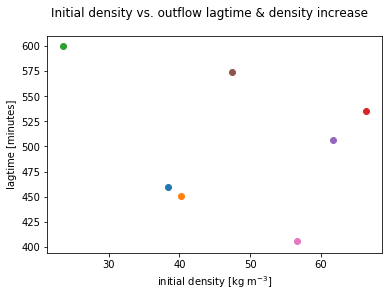

In [57]:
fig, ax1 = plt.subplots(figsize=(6,4))
# ax2 = ax1.twinx()

for exp in exps[2:]:
    ax1.scatter(exp_info[exp].outflow_lag.seconds/60,exp_info[exp].initrho_kgm3,label=exp)
#     ax2.scatter(exp_info[exp].initrho_kgm3,exp_info[exp].endrho_kgm3-exp_info[exp].initrho_kgm3,marker='x')
    
ax1.set_xlabel('initial density [kg $\mathregular{m^{-3}}$]')
ax1.set_ylabel('lagtime [minutes]')
# ax2.set_ylabel('total density increase [kg $\mathregular{m^{-3}}$]')
# ax2.set_ylim([-20,100])
# ax1.grid(linestyle='--')
# ax1.legend()
fig.suptitle('Initial density vs. outflow lagtime & density increase')

### Porosity and permeability
Porosity values for literature references calculated as $\phi = \rho_{snow}/\rho_{ice}$ with $\rho_{ice} = 913 kg/m^{3}$

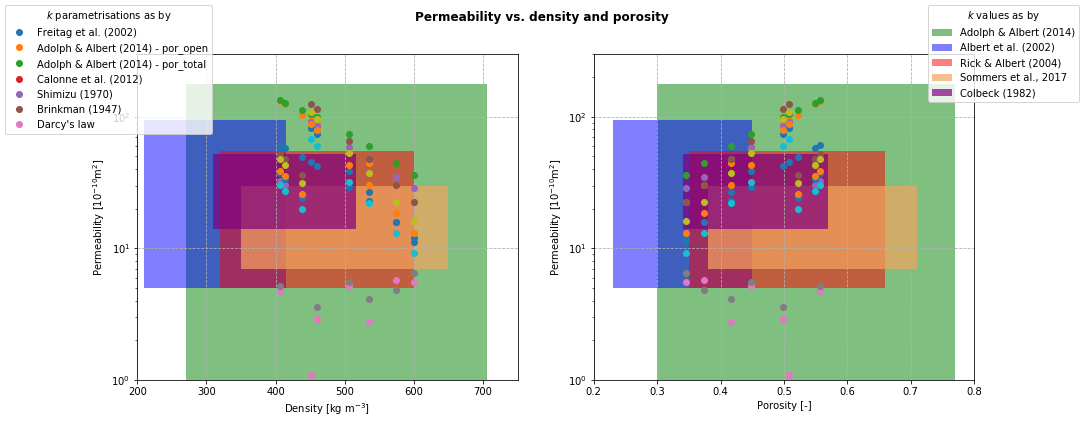

In [58]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.suptitle('Permeability vs. density and porosity',weight='bold')

ax1.plot(exp_info.loc['initrho_kgm3',:],permeability*10e9,'o')
ax1.broken_barh([(270,435)],(0,177),label='Adolph & Albert (2014)',facecolors='green',alpha=0.5)
ax1.broken_barh([(210,205)],(5,90),label='Albert et al. (2002)',facecolors='blue',alpha=0.5)
ax1.broken_barh([(320,280)],(5,50),label='Rick & Albert (2004)',facecolors='red',alpha=0.5)
ax1.broken_barh([(350,300)],(7,23),label='Sommers et al., 2017',facecolors='sandybrown',alpha=0.7)
ax1.broken_barh([(309,208)],(14,38),label='Colbeck (1982)',facecolors='purple',alpha=0.7)
ax1.set_xlim([200,750])
ax1.set_xlabel('Density [kg $\mathregular{m^{-3}}$]')
ax1.set_ylim([1,300])
ax1.set_ylabel('Permeability [$\mathregular{10^{-10} m^{2}}$]')
ax1.set_yscale('log')
ax1.grid(linestyle='--')

ax2.plot(exp_info.loc['porosity',:],permeability*10e9,'o')
ax2.broken_barh([(0.30,0.47)],(0,177),facecolors='green',alpha=0.5)
ax2.broken_barh([(0.23,0.22)],(5,90),facecolors='blue',alpha=0.5)
ax2.broken_barh([(0.35,0.31)],(5,50),facecolors='red',alpha=0.5)
ax2.broken_barh([(0.38,0.33)],(7,23),facecolors='sandybrown',alpha=0.7)
ax2.broken_barh([(0.34,0.23)],(14,38),facecolors='purple',alpha=0.7)
ax2.set_xlabel('Porosity [-]')
ax2.set_xlim([0.2,0.8])
ax2.set_ylim([1,300])
ax2.set_ylabel('Permeability [$\mathregular{10^{-10} m^{2}}$]')
ax2.set_yscale('log')
ax2.grid(linestyle='--')

fig.legend(['Freitag et al. (2002)','Adolph & Albert (2014) - por_open','Adolph & Albert (2014) - por_total','Calonne et al. (2012)','Shimizu (1970)', 'Brinkman (1947)','Darcy\'s law'],loc='upper left',title='$k$ parametrisations as by')
fig.legend(loc='upper right',title='$k$ values as by')
plt.savefig(os.path.join(output_dir,'perm_vs_rho_por.jpg'))

### Added mass
Assuming that all density increase remains in firn block as liquid water (i.e. no refreezing)

C:\Users\ClerxN\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


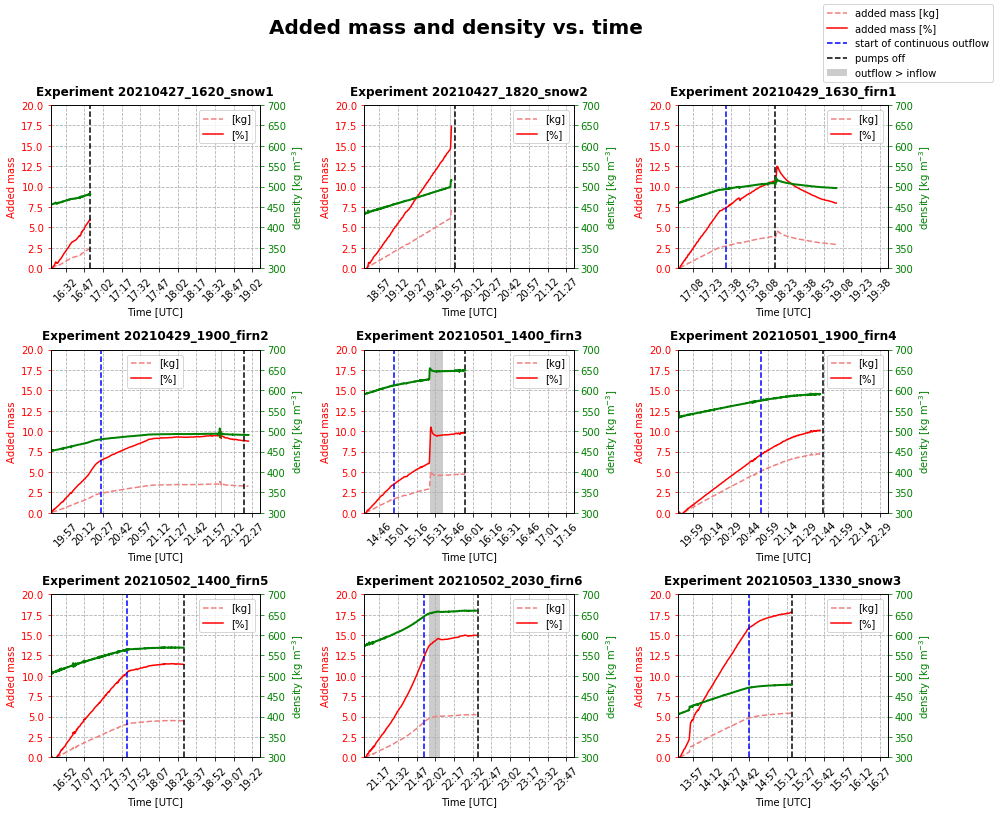

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,12))
fig.subplots_adjust(hspace = 0.5,wspace=0.5)

axes = axes.flatten()
for x, ax in enumerate(axes):
    ax.plot(exp_data[exps[x]].added_mass_kg,'lightcoral',ls='--',label='[kg]')
    ax.plot(exp_data[exps[x]].added_mass_perc,'r',label='[%]')
    ax.axvline(exp_info[exps[x]].outflow_start_DT,c='b',ls='--')
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('Added mass')    
    ax.yaxis.label.set_color('r')
    ax.tick_params(axis='y',colors='r')
    ax.set_ylim([0,20])
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(exp_data[exps[x]].density_kgm3,'g',linewidth=2,label='density')
    ax2.set_ylim([300,700])
    ax2.set_ylabel('density [kg $\mathregular{m^{-3}}$]')
    ax2.yaxis.label.set_color('g')
    ax2.tick_params(axis='y',colors='g')
    
    out_morethan_in_start= ((exp_data[exps[x]].outflow_int_L.rolling(window=6).mean().dropna() - exp_data[exps[x]].inflow_int_L.iloc[5:])>0).idxmax()
    out_morethan_in_end = ((exp_data[exps[x]].inflow_int_L.loc[out_morethan_in_start:] - exp_data[exps[x]].outflow_int_L.rolling(window=6).mean().loc[out_morethan_in_start:])<0).idxmin()
#     ax.axvline(out_morethan_in_start,c='purple',ls='dashed',label='start outflow > inflow')
    ax.axvline(exp_info[exps[x]].pumps_off_DT,c='k',ls='--',label='pumps off')
    ax.broken_barh([(out_morethan_in_start,(out_morethan_in_end-out_morethan_in_start))],(0,20),facecolors='grey',alpha=0.4)
  
    ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax.set_yticks(np.arange(0,21,2.5))
    ax.tick_params(axis='x',labelrotation=45)
    ax.set_xlim([exp_info[exps[x]].drplate_out_DT,exp_info[exps[x]].drplate_out_DT+pd.Timedelta(2.8,unit='h')])
    ax.grid(linestyle='--')
    ax.set_title('Experiment %s'%exps[x],weight='bold',pad=10)

labels=['added mass [kg]','added mass [%]','start of continuous outflow','pumps off','outflow > inflow']
fig.legend(labels=labels,loc='upper right')
# fig.legend(labels='density [kg $\mathregular{m^{-3}}$]')
fig.suptitle('Added mass and density vs. time',weight='bold',fontsize=20)

plt.savefig(os.path.join(output_dir,'addedmass_all.jpg'))

### Hydraulic conductivity over time

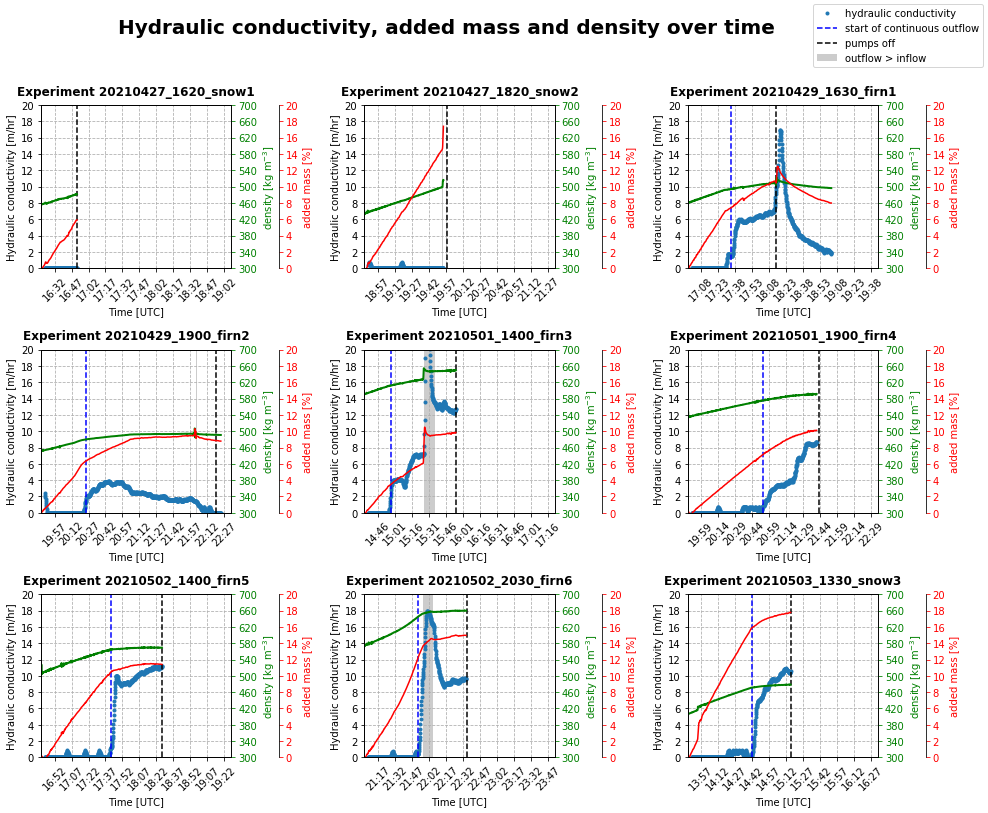

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,12))
fig.subplots_adjust(hspace=0.5,wspace=0.7)

axes = axes.flatten()
for x, ax in enumerate(axes):
    ax.plot(exp_data[exps[x]].K_Darcy.rolling(window=12).mean()*3600,'.',label='Hydraulic conductivity')
#     ax.plot(exp_data[exps[x]].K_Darcy_avg)
    ax.axvline(exp_info[exps[x]].outflow_start_DT,c='b',ls='--',label='start of continuous outflow')
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('Hydraulic conductivity [m/hr]')    
    ax.set_ylim([0,20])

    ax2 = ax.twinx()
    ax2.plot(exp_data[exps[x]].density_kgm3,'g',linewidth=2,label='density')
    ax2.set_ylim([300,700])
    ax2.set_yticks(np.arange(300,701,50))
    ax2.set_ylabel('density [kg $\mathregular{m^{-3}}$]')
    ax2.tick_params(axis='y',colors='g')
    ax2.yaxis.label.set_color('g')
        
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('axes',1.25))
    ax3.plot(exp_data[exps[x]].added_mass_perc,'r',label='added mass')
    ax3.yaxis.label.set_color('r')
    ax3.tick_params(axis='y',colors='r')
    ax3.set_ylim([0,20])
    ax3.set_ylabel('added mass [%]')   

    out_morethan_in_start= ((exp_data[exps[x]].outflow_int_L.rolling(window=6).mean().dropna() - exp_data[exps[x]].inflow_int_L.iloc[5:])>0).idxmax()
    out_morethan_in_end = ((exp_data[exps[x]].inflow_int_L.loc[out_morethan_in_start:] - exp_data[exps[x]].outflow_int_L.rolling(window=6).mean().loc[out_morethan_in_start:])<0).idxmin()
#     ax.axvline(out_morethan_in_start,c='purple',ls='dashed',label='start outflow > inflow')
    ax.axvline(exp_info[exps[x]].pumps_off_DT,c='k',ls='--',label='pumps off')
    ax.broken_barh([(out_morethan_in_start,(out_morethan_in_end-out_morethan_in_start))],(0,30),facecolors='grey',alpha=0.4)
  
    ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax.set_yticks(np.arange(0,21,2))
    ax2.set_yticks(np.arange(300,701,40))
    ax3.set_yticks(np.arange(0,21,2))
    ax.tick_params(axis='x',labelrotation=45)
    ax.set_xlim([exp_info[exps[x]].drplate_out_DT,exp_info[exps[x]].drplate_out_DT+pd.Timedelta(2.8,unit='h')])
    ax.grid(linestyle='--')
    ax.set_title('Experiment %s'%exps[x],weight='bold',pad=10)

labels=['hydraulic conductivity','start of continuous outflow','pumps off','outflow > inflow']
fig.legend(labels=labels,loc='upper right')
# fig.legend(labels='density [kg $\mathregular{m^{-3}}$]')
fig.suptitle('Hydraulic conductivity, added mass and density over time',weight='bold',fontsize=20)

plt.savefig(os.path.join(output_dir,'hydraulicconductivity_all.jpg'))

#### Plot for paper
##### adjusted time labels

In [63]:
exp_data_ = exp_data
t0 = dt.datetime.strptime('2021-04-01 00:00:00','%Y-%m-%d %H:%M:%S')

for exp in exps:
    exp_data_[exp].index = exp_data[exp].index-exp_data[exp].index[0]+t0

In [64]:
plt.close()
paper_exps = exps[2:]
fig = plt.figure(figsize=(11,10))
fig.subplots_adjust(left=0.1,right=0.88,top=0.95,hspace=0.65,wspace=0.125)
exp_data_ = exp_data

for x, exp in enumerate(paper_exps):
    ax = fig.add_subplot(3,3,x+1)
    ax.plot(exp_data_[exp].K_Darcy.rolling(window=12).mean()*3600,'.',c='b',label='_nolegend_')
    ax.axvline(t0+(exp_info[exp].outflow_start_DT-exp_info[exp].drplate_out_DT),c='k',ls=':',label='start of continuous outflow')
    ax.set_xlabel('Time after experiment start [HH:MM]')
    ax.set_ylim([0,20])
    if ((x-3) % 3 == 0):
        ax.set_ylabel('Hydraulic conductivity [m/hr]')    
        ax.yaxis.label.set_color('b')
        ax.tick_params(axis='y',colors='b')
        ax.yaxis.set_ticks_position('none')
    else:
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticks_position('both')
        ax.tick_params(axis='y',direction='in')
        ax.yaxis.set_ticklabels([])
    
    ax2 = ax.twinx()
    ax2.plot(exp_data_[exp].density_kgm3,'g',linewidth=2,label='density')
    ax2.set_ylim([300,700])
    ax2.set_yticks(np.arange(300,701,50))
    if ((x-1) % 3 == 1):
        ax2.set_ylabel('density [kg $\mathregular{m^{-3}}$]')
        ax2.tick_params(axis='y',colors='g')
        ax2.yaxis.label.set_color('g')
    elif ((x == 6)):
        ax2.set_ylabel('density [kg $\mathregular{m^{-3}}$]')
        ax2.tick_params(axis='y',colors='g')
        ax2.yaxis.label.set_color('g')
    else: 
        ax2.tick_params(axis='y',length=0,direction='in')
        ax2.yaxis.set_ticks([])
        ax2.yaxis.set_ticklabels([])
    
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('axes',1.25))
    ax3.plot(exp_data_[exp].added_mass_perc,'r',label='added mass')
    ax3.set_ylim([0,20])
    if ((x-1) % 3 == 1):
        ax3.yaxis.label.set_color('r')
        ax3.tick_params(axis='y',colors='r')
        ax3.set_ylabel('added mass [%]')
    elif (x == 6):
        ax3.yaxis.label.set_color('r')
        ax3.tick_params(axis='y',colors='r')
        ax3.set_ylabel('added mass [%]')     
    else:
        ax3.tick_params(length=0)
        ax3.yaxis.set_ticklabels([])    

    out_morethan_in_start= ((exp_data_[exp].outflow_int_L.rolling(window=6).mean().dropna() - exp_data_[exp].inflow_int_L.iloc[5:])>0).idxmax()
    out_morethan_in_end = ((exp_data_[exp].inflow_int_L.loc[out_morethan_in_start:] - exp_data_[exp].outflow_int_L.rolling(window=6).mean().loc[out_morethan_in_start:])<0).idxmin()
    ax.axvline(t0+(exp_info[exp].pumps_off_DT-exp_info[exp].drplate_out_DT),c='k',ls='--',label='pumps off')
    ax.broken_barh([(out_morethan_in_start,(out_morethan_in_end-out_morethan_in_start))],(0,30),facecolors='grey',alpha=0.4)
  
    ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax.set_yticks(np.arange(0,21,2))
    ax2.set_yticks(np.arange(300,701,40))
    ax3.set_yticks(np.arange(0,21,2))
    ax.tick_params(axis='x',labelrotation=45)
    ax.grid(linestyle='--')
    if x == 6:
        ax.set_title('$\it{%s}$ (%s-%s, %s:%s)'%(exp[-5:-1], exp[-13:-11], exp[-15:-13], exp[-10:-8], exp[-8:-6]),pad=10)
    else:
        ax.set_title('$\it{%s}$ (%s-%s, %s:%s)'%(exp[-5:], exp[-13:-11], exp[-15:-13], exp[-10:-8], exp[-8:-6]),pad=10)
    ax.set_xlim([t0,t0+pd.Timedelta(2.25,unit='h')])  
    
labels=['start of continuous outflow','pumps off','final 15 minutes','outflow > inflow']
fig.legend(labels=labels,loc='lower right',bbox_to_anchor=(0.7,0.1),fontsize=11)

# plt.savefig(os.path.join(output_dir,'ROSA_results1.pdf'))

### Plotting

#### Temperature plot for paper

In [131]:
plt.close('all')
exp = exps[4]

fig,ax = plt.subplots(2,1,figsize=(6,8))
fig.subplots_adjust(hspace=0.45)
ax[1].set_title('$\it{%s}$ (%s-%s, %s:%s)'%(exp[-5:], exp[-13:-11], exp[-15:-13], exp[-10:-8], exp[-8:-6]),pad=10)
ax[1].plot(exp_data_[exp].Airtemp_1,c='grey',ls='dotted',lw=2,label='T_air_top [°C]')
ax[1].plot(exp_data_[exp].Airtemp_3,c='grey',ls=(0, (5, 3, 1, 3, 1, 3)),lw=2,label='T_air_mid [°C]')
ax[1].plot(exp_data_[exp].Airtemp_2,c='grey',ls='--',lw=2,label='T_air_base [°C]')
ax[1].set_ylabel('Air temperatures at cage levels [°C]')
ax[1].plot(exp_data_[exp].Temp_1,label='T_firn_1 [°C]')
ax[1].plot(exp_data_[exp].Temp_2,label='T_firn_2 [°C]')
ax[1].plot(exp_data_[exp].Temp_3,label='T_firn_3 [°C]')
ax[1].plot(exp_data_[exp].Temp_4,label='T_firn_4 [°C]')

# ax.axhline(0,color='k',linewidth=1,dashes=[2,3])

ax[1].axvline(t0+(exp_info[exp].outflow_start_DT-exp_info[exp].drplate_out_DT),c='k',ls=':',label='start of outflow')
ax[1].axvline(t0+(exp_info[exp].pumps_off_DT-exp_info[exp].drplate_out_DT),c='k',ls='--',label='pumps off')
out_morethan_in_start= ((exp_data_[exp].outflow_int_L.rolling(window=6).mean().dropna() - exp_data_[exp].inflow_int_L.iloc[5:])>0).idxmax()
out_morethan_in_end = ((exp_data_[exp].inflow_int_L.loc[out_morethan_in_start:] - exp_data_[exp].outflow_int_L.rolling(window=6).mean().loc[out_morethan_in_start:])<0).idxmin()
ax[1].broken_barh([(out_morethan_in_start,(out_morethan_in_end-out_morethan_in_start))],(-15,25),facecolors='grey',alpha=0.4,label='outflow > inflow')
ax[1].set_ylabel('Temperature [°C]')
ax[1].set_ylim([-15,10])

ax[1].xaxis.set_major_locator(dates.MinuteLocator(interval=5))
ax[1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[1].tick_params(axis='x',labelrotation=45)
ax[1].tick_params(axis='y',labelright=True,right=True)
ax[1].set_xlim([t0,t0+pd.Timedelta(1.5,unit='h')])  
ax[1].set_xlabel('time after experiment start [HH:MM]')

exp = exps[2]
ax[0].plot(exp_data_[exp].Temp_1,label='T_firn_1 [°C]')
ax[0].plot(exp_data_[exp].Temp_2,label='T_firn_2 [°C]')
ax[0].plot(exp_data_[exp].Temp_3,label='T_firn_3 [°C]')
ax[0].plot(exp_data_[exp].Temp_4,label='T_firn_4 [°C]')

ax[0].plot(exp_data_[exp].Airtemp_1,c='grey',ls='dotted',lw=2,label='T_air_top [°C]')
ax[0].plot(exp_data_[exp].Airtemp_3,c='grey',ls=(0, (5, 3, 1, 3, 1, 3)),lw=2,label='T_air_mid [°C]')
ax[0].plot(exp_data_[exp].Airtemp_2,c='grey',ls='--',lw=2,label='T_air_base [°C]')
ax[0].set_ylabel('Air temperatures at cage levels [°C]')
# ax.axhline(0,color='k',linewidth=1,dashes=[2,3])

ax[0].axvline(t0+(exp_info[exp].outflow_start_DT-exp_info[exp].drplate_out_DT),c='k',ls=':',label='start of outflow')
ax[0].axvline(t0+(exp_info[exp].pumps_off_DT-exp_info[exp].drplate_out_DT),c='k',ls='--',label='pumps off')
out_morethan_in_start= ((exp_data_[exp].outflow_int_L.rolling(window=6).mean().dropna() - exp_data_[exp].inflow_int_L.iloc[5:])>0).idxmax()
out_morethan_in_end = ((exp_data_[exp].inflow_int_L.loc[out_morethan_in_start:] - exp_data_[exp].outflow_int_L.rolling(window=6).mean().loc[out_morethan_in_start:])<0).idxmin()
# ax[0].broken_barh([(out_morethan_in_start,(out_morethan_in_end-out_morethan_in_start))],(-15,25),facecolors='grey',alpha=0.4,label='outflow > inflow')
ax[0].set_ylabel('Temperature [°C]')
ax[0].set_ylim([-15,10])
ax[0].set_title('$\it{%s}$ (%s-%s, %s:%s)'%(exp[-5:], exp[-13:-11], exp[-15:-13], exp[-10:-8], exp[-8:-6]),pad=10)

ax[0].xaxis.set_major_locator(dates.MinuteLocator(interval=5))
ax[0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[0].tick_params(axis='x',labelrotation=45)
ax[0].tick_params(axis='y',labelright=True,right=True)
ax[0].set_xlim([t0,t0+pd.Timedelta(1.5,unit='h')])  
ax[0].set_xlabel('time after experiment start [HH:MM]')

ax[1].legend(bbox_to_anchor=(1.07,1),loc='upper left')

plt.savefig(os.path.join(output_dir,'ROSA_results3.pdf'),bbox_inches='tight')